# MLOps for Adult Lung Segmentation 

## Imports

In [1]:
import torch
from torch.utils.data import random_split
from torch import optim
import pytorch_lightning as pl
import torchmetrics.classification 

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from monai.losses import DiceCELoss
from monai.networks.nets import UNETR
from monai.data import DataLoader, Dataset
from monai.transforms import ( Compose, Resized, 
                              ToTensord, NormalizeIntensityd, 
                              LoadImaged, EnsureChannelFirstd, 
                              RandAffined )
import numpy as np
import glob
import SimpleITK as sitk
import pandas as pd
import csv

# Through pytorch lightning
from lightning.pytorch.loggers import MLFlowLogger

# Or directly:
import mlflow

print(torch.cuda.is_available())

True


## Create a data list csv file (can version this when excluding cases)

In [2]:
def file_path_to_abnormality(filepath):
    return bool(int(filepath[12]))

DATA_DIR = "../data" # CXR_png, ManualMask/leftMask, rightMask

montgomery_image_path = os.path.join(DATA_DIR,"MontgomerySet",'CXR_png')
montgomery_leftmask_path = os.path.join(DATA_DIR,"MontgomerySet",'ManualMask','leftMask')
montgomery_rightmask_path = os.path.join(DATA_DIR,"MontgomerySet",'ManualMask','rightMask')

# Montgomery dataset
data_list = []
list = os.listdir(montgomery_image_path)
for file in os.listdir(montgomery_image_path):
    if file.endswith('.png'):

        img_name = os.path.join(montgomery_image_path,file)
        left_name = os.path.join(montgomery_leftmask_path,file)
        right_name = os.path.join(montgomery_rightmask_path,file)

        data_list.append({
            'image': img_name,
            'seg_left': left_name,
            'seg_right': right_name,
            'source': 'montgomery',
            'tubercolosis': file_path_to_abnormality(file)
        })

shenzen_image_path = os.path.join(DATA_DIR,"ChinaSet_AllFiles","CXR")
shenzen_mask_path = os.path.join(DATA_DIR,"ChinaSet_AllFiles","CXR_segs")

# Shenzen dataset
list = os.listdir(shenzen_image_path)
for file in os.listdir(shenzen_image_path):
    if file.endswith('.png'):

        img_name = os.path.join(shenzen_image_path,file)
        seg_name = os.path.join(shenzen_mask_path,file)

        data_list.append({
            'image': img_name,
            'seg': left_name,
            'source': 'shenzen',
            'tubercolosis': file_path_to_abnormality(file)
        })

# Convet to csv and write to file. dvc can track this file for data versioning
data_forcsv = pd.DataFrame.from_dict(data_list)
pd.DataFrame.to_csv(data_forcsv,os.path.join(DATA_DIR, 'datalist.csv'), header = True,index = False)

display(data_forcsv)

,image,seg_left,seg_right,source,tubercolosis,seg
0,../data/MontgomerySet/CXR_png/MCUCXR_0102_0.png,../data/MontgomerySet/ManualMask/leftMask/MCUC...,../data/MontgomerySet/ManualMask/rightMask/MCU...,montgomery,False,NaN
1,../data/MontgomerySet/CXR_png/MCUCXR_0045_0.png,../data/MontgomerySet/ManualMask/leftMask/MCUC...,../data/MontgomerySet/ManualMask/rightMask/MCU...,montgomery,False,NaN
2,../data/MontgomerySet/CXR_png/MCUCXR_0369_1.png,../data/MontgomerySet/ManualMask/leftMask/MCUC...,../data/MontgomerySet/ManualMask/rightMask/MCU...,montgomery,True,NaN
3,../data/MontgomerySet/CXR_png/MCUCXR_0313_1.png,../data/MontgomerySet/ManualMask/leftMask/MCUC...,../data/MontgomerySet/ManualMask/rightMask/MCU...,montgomery,True,NaN
4,../data/MontgomerySet/CXR_png/MCUCXR_0077_0.png,../data/MontgomerySet/ManualMask/leftMask/MCUC...,../data/MontgomerySet/ManualMask/rightMask/MCU...,montgomery,False,NaN
...,...,...,...,...,...,...
795,../data/ChinaSet_AllFiles/CXR/CHNCXR_0648_1.png,NaN,NaN,shenzen,True,../data/MontgomerySet/ManualMask/leftMask/MCUC...
796,../data/ChinaSet_AllFiles/CXR/CHNCXR_0332_1.png,NaN,NaN,shenzen,True,../data/MontgomerySet/ManualMask/leftMask/MCUC...
797,../data/ChinaSet_AllFiles/CXR/CHNCXR_0338_1.png,NaN,NaN,shenzen,True,../data/MontgomerySet/ManualMask/leftMask/MCUC...
798,../data/ChinaSet_AllFiles/CXR/CHNCXR_0286_0.png,NaN,NaN,shenzen,False,../data/MontgomerySet/ManualMask/leftMask/MCUC...


## Custom Data Loader - using a Custom Dataset and Pytorch Lightning

In [3]:
# Only applied to training dataset
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample

    """
    def __init__(self, dataset, transform=None):

        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.dataset)
    
# Takes as input the path to files
class LungSegmentationDataset(Dataset):
    def __init__(self, datalist_filepath, transforms):
        
        self.data_list = pd.read_csv(datalist_filepath)
        self.transform = transforms

    def __len__(self):
        return self.data_list.shape[0]
    
    def file_path_to_ID(self,filepath):
        id = os.path.basename(filepath)[:-6]
        return id
    
    def __getitem__(self, idx):

        # Load Image and corresponding segmentation masks
        img_name = self.data_list.loc[idx,'image']
        img = sitk.GetArrayFromImage(sitk.ReadImage(img_name))

        # Shenzen images have 3 channels but all of them are the same
        if len(img.shape) == 3:
            img = img[:,:,0]

        if self.data_list.loc[idx,'source'] == 'montgomery':
            left_name = self.data_list.loc[idx,'seg_left']
            right_name = self.data_list.loc[idx,'seg_right']
            
            left = sitk.GetArrayFromImage(sitk.ReadImage(left_name))/255
            right = sitk.GetArrayFromImage(sitk.ReadImage(right_name))/255

            seg = left + right #  Combine the right and left masks

        elif self.data_list.loc[idx,'source'] == 'shenzen':
            seg_name = self.data_list.loc[idx,'seg']
            seg = sitk.GetArrayFromImage(sitk.ReadImage(seg_name))/255

        seg = seg.astype(int)
        sample = {'image':img,'label':seg,'id': self.file_path_to_ID(img_name)}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

### Testing out custom dataset

MCUCXR_0077
Number of training cases: 560
Number of validation cases: 160
Number of test cases: 80


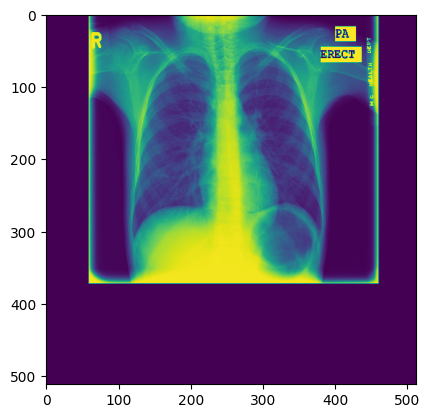

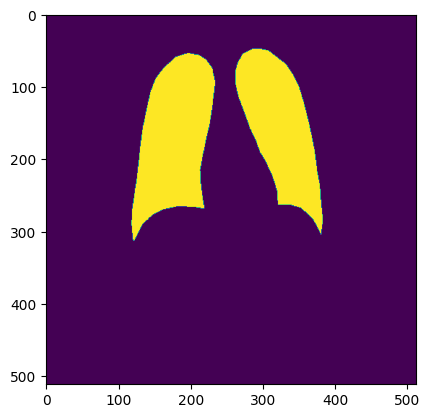

In [4]:
transforms = Compose([EnsureChannelFirstd(keys=['image','label'], channel_dim='no_channel'),
            Resized(keys=['image','label'], spatial_size = (512,512), mode=("bilinear","nearest")),      
            NormalizeIntensityd(keys=['image','label']),
            ToTensord(keys=['image','label'])])

aug_transforms = RandAffined(keys=['image','label'],mode=('bilinear','nearest'),prob=0.4,rotate_range=(np.pi/2, 0, 0))

ds = LungSegmentationDataset(os.path.join(DATA_DIR,'datalist.csv'),transforms=transforms)
aug_ds = ApplyTransform(ds, aug_transforms)

sample = aug_ds[4]

import matplotlib.pyplot as plt
img = sample["image"]
seg = sample["label"]
print(sample['id'])
plt.imshow(img[0])
plt.figure()
plt.imshow(seg[0])

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(ds,[0.7,0.2,0.1], generator=generator)
print("Number of training cases:", len(train_ds))
print("Number of validation cases:", len(val_ds))
print("Number of test cases:", len(test_ds))

train_dataloader = DataLoader(train_ds,
            batch_size = 2,
            num_workers = 0,
            shuffle=True)
        
val_dataloader =DataLoader(val_ds,
            batch_size = 2,
            num_workers = 0,
            shuffle=False)

test_dataloader =DataLoader(test_ds,
            batch_size = 2,
            num_workers = 0,
            shuffle=False)

## Lung Segmentation Data Module

In [5]:
class LungSegmentationDataModule(pl.LightningDataModule):
    def __init__(self, datalist_file, batch_size, num_workers):
        super().__init__()
        self.datalist_file = datalist_file
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.dims = 2

        self.transforms = Compose([EnsureChannelFirstd(keys=["image","label"], channel_dim='no_channel'), 
            Resized(keys=['image','label'], spatial_size = (512,512), mode=("bilinear","nearest")),
            NormalizeIntensityd(keys=['image']),
            ToTensord(keys=["image","label"])])
        
        self.aug_transforms = RandAffined(keys=['image','label'],mode=('bilinear','nearest'),prob=0.1,rotate_range=(0, 0, np.pi))

    def prepare_data(self):
        """
        Empty prepare_data method left in intentionally. 
        https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html#prepare-data
        This function is used if downloading data . Processes that occcur on a single processing unit
        """
        pass

    def setup(self, stage):

        # Assign train/val datasets for use in datlaloaders
        entire_dataset =  LungSegmentationDataset(
            self.datalist_file,
            transforms = self.transforms)
        
        # Split data
        generator = torch.Generator().manual_seed(42) # reproducible split
        self.train_ds, self.val_ds, self.test_ds = random_split(entire_dataset,[0.7,0.2,0.1], generator=generator)

        # Apply data augmentation transfprms to train_ds
        self.train_ds = ApplyTransform(self.train_ds, self.aug_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=True)
        
    def val_dataloader(self):
        return DataLoader(self.val_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=False)

# Define Network

In [6]:
class Net(pl.LightningModule):
    def __init__(self, input_size, num_classes, learning_rate):
        super().__init__()

        self.model = UNETR(in_channels = 1, out_channels = num_classes, img_size = input_size, spatial_dims=2)
        self.loss = DiceCELoss(to_onehot_y=True, softmax=True)
        self.learning_rate = learning_rate
        self.train_dice = torchmetrics.classification.Dice(num_classes=2)
        self.val_dice = torchmetrics.classification.Dice(num_classes=2)

    def forward(self,x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        print(self.learning_rate)
        return optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch,batch_idx)
        dice = self.train_dice(pred, y)
        self.log_dict({"train_loss":loss, "train_dsc": dice}, on_epoch = True, on_step = False)
        return loss
        # can return loss, log values

    def validation_step(self, batch, batch_idx):
        # validation loigic
        loss, pred, y = self.common_step(batch,batch_idx)
        dice = self.val_dice(pred, y)
        self.log_dict({"val_loss":loss, "val_dsc": dice}, on_epoch = True, on_step = False)
        #mlflow.log_metric("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch,batch_idx)
        return loss, pred, y

    def common_step(self, batch, batch_idx):
        # training logic
        x = batch["image"]
        y = batch["label"].int()

        pred = self.forward(x)
        loss = self.loss(pred,y)

        return loss, pred, y
    
    def predict_step(self, batch, batch_idx):
        x = batch["image"]

        pred = self.forward(x)
        pred = pred.softmax(dim = 1) # Convert to probability map
        preds = torch.argmax(pred, dim=1)
        return preds


In [7]:
# Hyperparameters

config = {'input_size':(512,512),
    'num_classes':2,
    'learning_rate':0.001,
    'batch_size':4,
    'num_epochs':150,
    'num_workers':0,
    'learning_rate':0.01
}


# Start training - Main code 

In [8]:
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

## MLFlow related details

In [2]:
mlflow_uri = "http://localhost:5000"
experiment_name = "FullDatasetLungSeg"
run_name="baseline"

experiment_description = (
     "Adult Lung segmentation from 2D Chest X-Rays"
 )

experiment_tags = {
     "project_name": "LungAirSeg_MLOps",
     "Dataset": "Montogmery + Shenzen",
     "mlflow.note.content": experiment_description
 }

In [10]:
mlflow.end_run()

# Using a combination of direct mlflow logging and pytorch lightning logger
mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment(experiment_name)
mlflow.pytorch.autolog()
mlflow.start_run(run_name=run_name)
mlflow.set_experiment_tags(experiment_tags)

mlflow.log_params(config)

# mlf_logger.experiment.log_artifact(
#     run_id=mlf_logger.run_id,
#     local_path=checkpoint_callback.best_model_path)

# With pytorch lightining
#Create a logger - written this way to ensure that pytorch logger is consistent with direct mlflow logger
mlf_logger = MLFlowLogger(experiment_name=mlflow.get_experiment(mlflow.active_run().info.experiment_id).name,
    tracking_uri=mlflow.get_tracking_uri(),
    run_id=mlflow.active_run().info.run_id)

    # #mlflow.set_tag()
# data module
dm = LungSegmentationDataModule(os.path.join(DATA_DIR,'datalist.csv'),batch_size=config['batch_size'], num_workers=config['num_workers'])
print(torch.cuda.is_available())

# Network
model = Net(input_size=config['input_size'], num_classes=config['num_classes'], learning_rate=config['learning_rate'])

# Trainer
trainer = pl.Trainer(min_epochs=0, max_epochs=config['num_epochs'], accelerator = "gpu", logger = mlf_logger, log_every_n_steps = 5)

trainer.fit(model,dm)
trainer.validate(model,dm)
# trainer.test(model,dm)

mlflow.end_run()

True


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | model      | UNETR      | 87.9 M
1 | loss       | DiceCELoss | 0     
2 | train_dice | Dice       | 0     
3 | val_dice   | Dice       | 0     
------------------------------------------
87.9 M    Trainable params
0         Non-trainable params
87.9 M    Total params
351.621   Total estimated model params size (MB)


0.01


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/sadhanar/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/sadhanar/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/sadhanar/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
2024/01/15 22:09:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/sadhanar/miniconda3/envs/mlops/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sadhanar/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_dsc          │    0.9334362149238586     │
│         val_loss          │    0.4856393337249756     │
└───────────────────────────┴───────────────────────────┘

# Download MLflow artifacts and run inference

In [3]:
mlflow.set_tracking_uri(mlflow_uri)
run_id = "b093cd2d5b2c4c9db5e8c756dd76cedf"
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path="../models/")

c:\Users\sadhana.ravikumar\anaconda3\envs\mlops\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MlflowException: The following failures occurred while downloading one or more artifacts from http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts:
##### File model/conda.yaml #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/conda.yaml failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/conda.yaml (Caused by ResponseError('too many 500 error responses'))
##### File model/MLmodel #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/MLmodel failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/MLmodel (Caused by ResponseError('too many 500 error responses'))
##### File model/data/model.pth #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/data/model.pth failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/data/model.pth (Caused by ResponseError('too many 500 error responses'))
##### File model/data/pickle_module_info.txt #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/data/pickle_module_info.txt failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/data/pickle_module_info.txt (Caused by ResponseError('too many 500 error responses'))
##### File model_summary.txt #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model_summary.txt failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model_summary.txt (Caused by ResponseError('too many 500 error responses'))
##### File model/requirements.txt #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/requirements.txt failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/requirements.txt (Caused by ResponseError('too many 500 error responses'))
##### File model/python_env.yaml #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/python_env.yaml failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/486829024399707616/b093cd2d5b2c4c9db5e8c756dd76cedf/artifacts/model/python_env.yaml (Caused by ResponseError('too many 500 error responses'))